# W207 Project 2
## Jacob Sycoff


# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
#These are some functions created for formatting. Note that not all sections will be standardized and therefore
#Not all sections will use these functions for their formatting
def bold_print(*args):
    start = "\033[1m"
    end = "\033[0;0m"
    string = ''
    for i in range(len(args)):
        element = args[i]
        if type(element) != str:
            element = str(element)
        string+= element+' '
    print(start+string+end)
    
def proj_section_header(num):
    '''input project part number and this function will output a standardized heading for that project part'''
    bold_print('Project Part',str(num),':') 
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()
    print()
    
def header(text):
    bold_print(text)
    print()

def sub_header(text):
    bold_print(text)
    print('---------------------------------------------------')

def end_section():
    print('----------------------------------------------------------------------------------------------------------------------')
    print()
    print()

### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [4]:
def P1(num_examples=5):
    ### STUDENT START ###
    proj_section_header(1)
    start = "\033[1m"
    end = "\033[0;0m"    
    for i in range(num_examples):
        print(start+'Example Number: '+end, i+1)    
        print(start+'Label: '+end, train_labels[i])
        print(start + 'Text:' + end)
        print(train_data[i])
        print('-----------------------------------------------------------------------------------------------------------')
        print('\n')
        print('\n')
    
    
    ### STUDENT END ###

P1(5)

Project Part 1 : 
~~~~~~~~~~~~~~~~~~~~~~~~~


Example Number:  1
Label:  1
Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
-----------------------------------------------------------------------------------------------------------




Example Number:  2
Label:  3
Text:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him,

### Part 2:

#### A)
Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

#### B)
Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

#### C)
Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

#### D)
Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

#### E)
Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [5]:
def P2():
    ### STUDENT START ###
    proj_section_header(2)
    #Section A:
    cv = CountVectorizer()
    fit_transformed_cv = cv.fit_transform(train_data)
    #The size of the vocabulary:
    vocab_size = fit_transformed_cv.shape[1]
    #this gives the same answer: vocab_size = len(cv.get_feature_names())
    bold_print('A)  Training data transformed into a matrix of word unigram feature vectors:')
    print("The size of the vocabulary is: ",vocab_size)

    #The average number of non-zero features per example:
    def average_nnz_features_per_ex(CV, nonzero_l = False):
        """input transformed count vectorizer and it outputs the average number of non-zero features per element"""
        ft_cv_array = CV.toarray()
        nonzero_lens = []
        for i in ft_cv_array:
            num_nonzero = 0
            for j in i:
                if j >0:
                    num_nonzero +=1
            nonzero_lens.append(num_nonzero)
        average_num_nonzero_features = np.mean(nonzero_lens)
        print("The average number of non-zero features per example is: ", average_num_nonzero_features)
        if nonzero_l == True:
            return(nonzero_lens)
    nonzero_lens = average_nnz_features_per_ex(fit_transformed_cv, nonzero_l = True)
    #The fraction of the non-zero entries in the matrix:
    total_len = fit_transformed_cv.shape[0]*fit_transformed_cv.shape[1]
    nonzero_len = sum(nonzero_lens)
    #gives same answer nonzero_len = fit_transformed_cv.count_nonzero()
    frac_of_nonzero_entries = nonzero_len/total_len
    print("The fraction of the non-zero entries in the matrix is: ", frac_of_nonzero_entries)

    #The 0th and last feature strings (in alphabetical order):
    print("The 0th feature string is: ",cv.get_feature_names()[0])
    print("The last feature string is: ",cv.get_feature_names()[-1])
    print()



    #Section B
    bold_print('B)', ' Vocabulary limited to ["atheism", "graphics", "space", "religion"]:')
    #Now transform the training data into a matrix of word unigram feature vectors using your own vocabulary with these
    #4 words: ["atheism", "graphics", "space", "religion"]. 
    vocab = ["atheism", "graphics", "space", "religion"]
    cv_vocab_limited = CountVectorizer(vocabulary=vocab)
    transformed_cv_vocab_lim = cv_vocab_limited.transform(train_data)

    #Confirm the size of the vocabulary. 
    limited_vocab_size = transformed_cv_vocab_lim.shape[1]
    print("The size of the vocabulary after limiting the vocabulary to 4 words is confirmed to be: ",limited_vocab_size)

    #What is the average number of non-zero features per example?
    avg_nnz_per_ex_lim = average_nnz_features_per_ex(transformed_cv_vocab_lim)
    print("The average number of non-zero features per example after limiting the vocabulary to 4 words is: ",avg_nnz_per_ex_lim)
    print()



    #Section C
    #Transform the training data into a matrix of character bigram and trigram feature vectors.
    bold_print("C) Training data transformed into matrix of character bigram and trigram feature vectors:")
    cv_bitrigram = CountVectorizer(analyzer='char', ngram_range=(2,3))
    ft_cv_bitrigram = cv_bitrigram.fit_transform(train_data)

    #What is the size of the vocabulary?
    bitrigram_vocabsize = ft_cv_bitrigram.shape[1]
    print("The size of the vocabulary is: ",bitrigram_vocabsize)
    print()



    #Section D
    #Now transform the training data into a matrix of word unigram feature vectors and prune words that appear
    #in fewer than 10 documents.
    bold_print("D) Training data transformed into matrix of word unigram feature vectors and words that appear in fewer \
than 10 documents pruned:")
    cv_unigram_pruned = CountVectorizer(min_df = 10, analyzer='word')
    ft_cv_unigram_pruned = cv_unigram_pruned.fit_transform(train_data)

    #What is the size of the vocabulary?
    unigram_pruned_vocabsize = ft_cv_unigram_pruned.shape[1]
    print("The size of the vocabulary is: ", unigram_pruned_vocabsize)
    print()



    #Section E
    # Now again transform the training data into a matrix of word unigram feature vectors.
    bold_print("E) Training data transformed into a matrix of word unigram feature vectors")
    cv_unigram_unpruned = CountVectorizer(analyzer='word')
    train_ft_cv_unigram_unpruned = cv_unigram_unpruned.fit_transform(train_data)

    dev_cv_unigram_unpruned = CountVectorizer(analyzer='word')
    dev_ft_cv_unigram_unpruned = dev_cv_unigram_unpruned.fit_transform(dev_data)

    #What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
    train_ft_cv_unigram_unpruned_vocab = cv_unigram_unpruned.get_feature_names()
    dev_ft_cv_unigram_unpruned_vocab = dev_cv_unigram_unpruned.get_feature_names()

    num_in_dev_not_training = 0
    for i in dev_ft_cv_unigram_unpruned_vocab:
        if i not in train_ft_cv_unigram_unpruned_vocab:
            num_in_dev_not_training+=1
    frac_in_dev_missing_from_training = num_in_dev_not_training/len(dev_ft_cv_unigram_unpruned_vocab)
    print('The fraction of words in the development vocabulary missing from the training vocabulary is:  ',frac_in_dev_missing_from_training)
    #_Hint: Build vocabularies for both train and dev and look at the size of the difference._
    end_section()
    ### STUDENT END ###
    
    
P2()

Project Part 2 : 
~~~~~~~~~~~~~~~~~~~~~~~~~


A)  Training data transformed into a matrix of word unigram feature vectors: 
The size of the vocabulary is:  26879
The average number of non-zero features per example is:  96.70599803343165
The fraction of the non-zero entries in the matrix is:  0.0035978272269590263
The 0th feature string is:  00
The last feature string is:  zyxel

B)  Vocabulary limited to ["atheism", "graphics", "space", "religion"]: 
The size of the vocabulary after limiting the vocabulary to 4 words is confirmed to be:  4
The average number of non-zero features per example is:  0.26843657817109146
The average number of non-zero features per example after limiting the vocabulary to 4 words is:  None

C) Training data transformed into matrix of character bigram and trigram feature vectors: 
The size of the vocabulary is:  35478

D) Training data transformed into matrix of word unigram feature vectors and words that appear in fewer than 10 documents pruned: 
The size of 

### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [6]:
def P3():
    ### STUDENT START ###
    #Part 3:
    proj_section_header(3)
    #Transform the training and development data to matrices of word unigram feature vectors.
    train_cv_unigram = CountVectorizer(analyzer='word')
    train_ft_cv_unigram = train_cv_unigram.fit_transform(train_data)
    dev_t_cv_unigram = train_cv_unigram.transform(dev_data)

    #Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. 
    #For each model, show the k value and f1 score.
    bold_print('Part 3 Subsection 1: Several k-Nearest Neigbors models are produced by varying k, including one with \
k set to optimize f1 score.')
    print()
    def make_knn(num_neighbors, train_data, train_labels, dev_data, dev_labels):
        '''This function creates a knn model with specified k value and outputs k value and f1 score'''
        knn = KNeighborsClassifier(n_neighbors = num_neighbors)
        knn.fit(train_data, train_labels)
        knn_dev_preds = knn.predict(dev_data)
        f1 = metrics.f1_score(dev_labels, knn_dev_preds, average="weighted")
        #print('K Value: ', num_neighbors)
        #print('f1 score: ',f1)
        output_list = [num_neighbors, f1]
        return output_list
    def find_best_knn(train_data, train_labels, dev_data, dev_labels)  :
        '''input train and dev data and labels and output knn with various k values and the resultant f1 score. 
        The k value that produces the best f1 score will be shown first '''
        list_of_lists = []
        for i in range(1,500,10):
            k_f1 = make_knn(i, train_data, train_labels, dev_data, dev_labels)
            list_of_lists.append(k_f1)
        sorted_list_of_lists = sorted(list_of_lists, key=lambda x: x[1], reverse = True)
        iteration = 0
        print("k-values between 1 and 500 were tested with a step size of 10. These tests were sorted by f1 value. \
The top result, as well as one out of every 5 tests done, is shown")
        print()
        for i in sorted_list_of_lists[0:500:5]:
            if iteration == 0:
                bold_print('This is the K value with the best f1 score:')
                print('K Value: ', i[0])
                print('f1 score: ',i[1])
                print('---------------------------------------------------')
                print()
                iteration+=1
            else:
                print('K Value: ', i[0])
                print('f1 score: ',i[1])
    find_best_knn(train_ft_cv_unigram, train_labels, dev_t_cv_unigram, dev_labels)
    print('------------------------------------------------------------------------------------------------------------------')
    print()

    #Subsection 2
    #Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set 
    #approximately to optimize f1 score. For each model, show the alpha value and f1 score.
    bold_print('Part 3 Subsection 2: Several Naive Bayes models are produced by varying smoothing (alpha), including \
one with alpha set approximately to optimize f1 score. For each model, the alpha value and f1 score is shown.')
    def make_mnb(alpha_value, train_data, train_labels, dev_data, dev_labels):
        '''This function creates a multinomial Naive Bayes model with specified alpha value and outputs alpha value and f1 score'''
        mnb = MultinomialNB(alpha = alpha_value)
        mnb.fit(train_data, train_labels)
        mnb_dev_preds = mnb.predict(dev_data)
        f1 = metrics.f1_score(dev_labels, mnb_dev_preds, average="weighted")
        output_list = [alpha_value, f1]
        return output_list
    def mnb_find_best_alpha(train_data, train_labels, dev_data, dev_labels, alpha_range = np.arange(0.001,3,.005), step_size = .005)  :
        '''input train and dev data and labels and output knn with various k values and the resultant f1 score. 
        The k value that produces the best f1 score will be shown first '''
        list_of_lists = []
        for i in alpha_range:
            a_f1 = make_mnb(i, train_data, train_labels, dev_data, dev_labels)
            list_of_lists.append(a_f1)
        sorted_list_of_lists = sorted(list_of_lists, key=lambda x: x[1], reverse = True)
        iteration = 0
        print("alpha-values between",alpha_range[0], ' and ', round(alpha_range[-1]), 'with a step size of ', step_size, 'were tested. These tests were sorted by f1 value. \
The top result, as well as one out of every', round(len(alpha_range)/10),'tests done, is shown')
        print()
        for i in sorted_list_of_lists[0:-1:round(len(alpha_range)/10)]:
            if iteration == 0:
                bold_print('This is the alpha value with the best f1 score')
                print('Alpha Value: ', i[0])
                print('f1 score: ',i[1])
                print('------------------------------------------------')
                print()
                iteration+=1
            else:
                print('Alpha Value: ', i[0])
                print('f1 score: ',i[1])
    mnb_find_best_alpha(train_ft_cv_unigram, train_labels, dev_t_cv_unigram, dev_labels)
    print('------------------------------------------------------------------------------------------------------------------')
    print()

    #Subsection 3
    #Produce several Logistic Regression models by varying L2 regularization strength (C), 
    #including one with C set approximately to optimize f1 score. For each model, show the C value, f1 score, 
    #and sum of squared weights for each topic.
    bold_print('Part 3 Subsection 3: Several Logistic Regression models are produced by varying L2 regularization \
strength (C), including one with C set approximately to optimize f1 score. For each model, the C value, f1 score, \
and sum of squared weights for each topic are shown.')

    topics = newsgroups_train.target_names
    def sum_of_squared_weights(log_reg, topics):
        '''This function takes a fitted logistic regression and a list of topics and outputs a list of the sum of 
        the squared coefficients for each topic'''
        coefs = log_reg.coef_
        squared_coefs = np.square(coefs)
        sum_squared_coefs = []
        for i in range(len(topics)):
            sum_squared_coefs.append(np.sum(squared_coefs[i]))
        ssc_dict = {topics[i]:sum_squared_coefs[i] for i in range(len(topics))}
        return ssc_dict

    def make_log_reg(c_value, train_data, train_labels, dev_data, dev_labels):
        '''This function creates a multinomial Naive Bayes model with specified L2 regularization strength (C) 
        value and outputsL2 regularization strength (C) and f1 score'''
        log_reg = LogisticRegression(C=c_value, solver="liblinear", multi_class="auto") 
        log_reg.fit(train_data, train_labels)
        log_reg_dev_preds = log_reg.predict(dev_data)
        f1 = metrics.f1_score(dev_labels, log_reg_dev_preds, average="weighted")
        ssc = sum_of_squared_weights(log_reg, topics)
        output_list = [c_value, f1, ssc]
        return output_list

    def log_reg_find_best_c(train_data, train_labels, dev_data, dev_labels, c_range = np.arange(.1,10,.25), step_size = .25)  :
        '''input train and dev data and labels and output knn with various k values and the resultant f1 score. 
        The k value that produces the best f1 score will be shown first '''
        list_of_lists = []
        for i in c_range:
            c_f1 = make_log_reg(i, train_data, train_labels, dev_data, dev_labels)
            list_of_lists.append(c_f1)
        sorted_list_of_lists = sorted(list_of_lists, key=lambda x: x[1], reverse = True)
        iteration = 0
        print("L2 regularization strength (C)-values between",c_range[0], ' and ', round(c_range[-1]),
              'with a step size of ', step_size, 'were tested. These tests were sorted by f1 value. \
The top result, as well as one out of every', round(len(c_range)/10),'tests done, is shown')
        print()
        for i in sorted_list_of_lists[0:-1:round(len(c_range)/10)]:
            if iteration == 0:
                bold_print('This is the L2 regularization strength (C) value with the best f1 score')
                print('L2 regularization strength (C): ', i[0])
                print('f1 score: ',i[1])
                for topic_index in range(len(topics)):
                    the_key = list(i[2].keys())[topic_index]
                    the_val = i[2][the_key]
                    print('Sum of squared weights for ', the_key,':',the_val)
                print('------------------------------------------------')
                print()
                iteration+=1
            else:
                if iteration ==1:
                    bold_print('These are a sample of the tests done with different L2 regularization \
strengths (C values).  One out of every', round(len(c_range)/10),'tests done, sorted the resultant f1 value, is shown:')
                    print()
                    iteration+=1
                print('L2 regularization strength (C): ', i[0])
                print('f1 score: ',i[1])
                for topic_index in range(len(topics)):
                    the_key = list(i[2].keys())[topic_index]
                    the_val = i[2][the_key]
                    print('Sum of squared weights for ', the_key,':',the_val)
                print('------------------------------------------')
    log_reg_find_best_c(train_ft_cv_unigram, train_labels, dev_t_cv_unigram, dev_labels, c_range = np.arange(.01,8,.25), 
                        step_size = .25)


    print('------------------------------------------------------------------------------------------------------------------')
    print()

    ### STUDENT END ###

P3()

Project Part 3 : 
~~~~~~~~~~~~~~~~~~~~~~~~~


Part 3 Subsection 1: Several k-Nearest Neigbors models are produced by varying k, including one with k set to optimize f1 score. 

k-values between 1 and 500 were tested with a step size of 10. These tests were sorted by f1 value. The top result, as well as one out of every 5 tests done, is shown

This is the K value with the best f1 score: 
K Value:  111
f1 score:  0.47574341744406534
---------------------------------------------------

K Value:  31
f1 score:  0.4469785852923378
K Value:  141
f1 score:  0.43871328845048274
K Value:  51
f1 score:  0.4136421528038719
K Value:  221
f1 score:  0.40076635272100897
K Value:  241
f1 score:  0.37816588710569415
K Value:  271
f1 score:  0.37057799159612825
K Value:  411
f1 score:  0.3490409291193754
K Value:  391
f1 score:  0.3446667415089202
K Value:  361
f1 score:  0.3360356515273082
------------------------------------------------------------------------------------------------------------------

##### ANSWER:
Why doesn't k-Nearest Neighbors work well for this problem?
               
    k-Nearest Neighbors doesn't work well for this problem because of the sparse nature of the data. All of the 0 values skew the data and the simplicity of knn doesn't have a way to correct for this
    

What is the relationship b
etween logistic regression's sum of squared weights vs. C value?   
     
     In general, sum of squared weights and c value are positively correlated
    

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [62]:
#def P4():
    ### STUDENT START ###
proj_section_header(4)
#Transform the data to a matrix of word bigram feature vectors.
import pandas as pd
train_cv_bigram = CountVectorizer(analyzer='word',ngram_range=(2,2))
train_ft_cv_bigram = train_cv_bigram.fit_transform(train_data)
p4logreg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
p4logreg.fit(train_ft_cv_bigram, train_labels)
weights = p4logreg.coef_
argsort_weights = np.argsort(weights)
heaviest = np.zeros((4,5))
for i in range(4):
    for j in range(5):
        heaviest[i][j] = argsort_weights[i][j]

topics = newsgroups_train.target_names
features = np.reshape(heaviest,20)









features = [int(i) for i in features]
def get_weight_given_feature_and_word(topic_index, feature_index):
    weight = weights[topic_index][feature_index]
    return weight
lol = []
for i in range(len(topics)):
    lol.append([])
    for j in features:
        lol[i].append(get_weight_given_feature_and_word(i, j))

#lol
df_precurser = {topics[i]:lol[i] for i in range(len(topics))}
weight_table = pd.DataFrame(df_precurser)
weight_table.index = [train_cv_bigram.get_feature_names()[i] for i in features]
weight_table

    ### STUDENT END ###

#P4()

Project Part 4 : 
~~~~~~~~~~~~~~~~~~~~~~~~~




,alt.atheism,comp.graphics,sci.space,talk.religion.misc
looking for,-0.630341,1.108371,-0.499937,-0.571863
want to,-0.460364,0.035035,0.110836,0.172469
for the,-0.459740,0.257016,-0.067346,-0.149038
in advance,-0.459351,0.832571,-0.438504,-0.418456
interested in,-0.444668,0.381481,-0.085709,-0.083657
cheers kent,0.555719,-0.697915,-0.663783,0.534807
that the,0.115706,-0.600153,0.093424,0.113831
the space,-0.268187,-0.530087,0.871147,-0.273844
the moon,-0.350563,-0.492711,0.831234,-0.213783
the bible,0.303153,-0.422065,-0.508411,0.334591


ANSWER: It is surprising that there are repeat bigram features due to multiple of the words(labels) having the same most heavily weighted bigrm features.



### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [13]:
def better_preprocessor(s):
    ### STUDENT START ###
 

#these are some functions tried for preprocessing
    def make_data_lowercase(data):
        data = data.lower()
        return data

    def remove_special(data):
        data=re.sub("\\W"," ",data)
        return data

    def remove_stops(data):
        data = make_data_lowercase(data)
        split = data.split()
        gerundless_i = []
        for word in split:
            if word in ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]:
                pass
            else:
                gerundless_i.append(word)               
        unsplit = ' '
        unsplit = unsplit.join(gerundless_i)
        return unsplit

    def make_data_gerundless_and_no_magic_e(data):
        split = data.split()
        gerundless_i = []
        for word in split:   
            if word.endswith('ing'):
                word = word[0:-3]
                gerundless_i.append(word)
            #elif word.endswith('e'):
             #   word = word[0:-1]
              #  gerundless_i.append(word)                
            else:
                gerundless_i.append(word)
        unsplit = ' '
        unsplit = unsplit.join(gerundless_i)
        return unsplit

    def replace_numbers(data):
        split = data.split()
        gerundless_i = []
        for word in split:
            for num in range(10):
                if str(num) in word:
                    word = 'number'
            gerundless_i.append(word)               
        unsplit = ' '
        unsplit = unsplit.join(gerundless_i)

        return unsplit


    def norm(data):
        data=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",data)
        return data


    def combined(data):
        data = remove_stops(data)
        data = make_data_gerundless_and_no_magic_e(data)
        data = remove_special(data)
        data = norm(data)
        data = replace_numbers(data)
        return data

    def remove_not_alphanumeric(data):
        data = "".join(i for i in data if i.isalnum())
        return data


    list_of_preprocessors = [norm, remove_stops, replace_numbers, remove_special,make_data_lowercase, 
                             make_data_gerundless_and_no_magic_e, combined]

#this is the final conglomerate function used for preprocerssing
    def best_combo(data):
        data = remove_stops(data)
        #data = make_data_gerundless_and_no_magic_e(data)
        data = remove_special(data)
        data = norm(data)
       # data = replace_numbers(data)
        return data
    s = best_combo(s)
    return s
        ### STUDENT END ###

    
    
def P5():
    ### STUDENT START ###
    proj_section_header(5)
    print()
    #This function makes a logistic regression model wih c=.5 and outputs dictionary size and f1 score.
    #It has an optional argument to preprocess data with a user defined function
    def make_log_reg_prepocessing_option(train_data, train_labels, dev_data, dev_labels, preprocessor = False, return_dict = False):
        '''This function creates a multinomial Naive Bayes model with L2 regularization strength (C) = .5 
        and outputs dictionary size and f1 score. It contains the ability to preprocess data with multiple
        available preprocessing options. input either false or a list with the proprocessing choices'''
        if preprocessor == False:
            train_cv_unigram = CountVectorizer(analyzer='word')
        else:
            train_cv_unigram = CountVectorizer(preprocessor=preprocessor ,analyzer='word')
        train_ft_cv_unigram = train_cv_unigram.fit_transform(train_data)
        dev_t_cv_unigram = train_cv_unigram.transform(dev_data)
        log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto") 
        log_reg.fit(train_ft_cv_unigram, train_labels)
        log_reg_dev_preds = log_reg.predict(dev_t_cv_unigram)
        f1 = metrics.f1_score(dev_labels, log_reg_dev_preds, average="weighted")
        dict_size = len(train_cv_unigram.get_feature_names())
        if return_dict == False:
            print('f1 score: ',f1)
            print('Vocabulary Size: ', dict_size)
        elif return_dict == True:
            return {'f1':f1,'vocab_size':dict_size}

   

    #1. Produce a Logistic Regression model (with no preprocessing of text).
    #1. Evaluate and show its f1 score and size of the dictionary.
    bold_print('1. A Logistic Regression model (with no preprocessing of text) is produced. Its f1 score and \
dictionary size are shown')
    make_log_reg_prepocessing_option(train_data, train_labels, dev_data, dev_labels, preprocessor = False)    
    print('------------------------------------------------------------------------------------------------')
   
    #2. Produce an improved Logistic Regression model by preprocessing the text. 
    #2. Evaluate and show its f1 score and size of the vocabulary. Try for an improvement in f1 score of at least 0.02.
    bold_print('2. An improved Logistic Regression model is produced by preprocessing the text. \
Its f1 score and dictionary size are shown')
    make_log_reg_prepocessing_option(train_data, train_labels, dev_data, dev_labels, preprocessor = better_preprocessor)
    print('------------------------------------------------------------------------------------------------')              

    #3. How much did the improved model reduce the vocabulary size?
    ### STUDENT END ###
    no_prepro = make_log_reg_prepocessing_option(train_data, train_labels, dev_data, dev_labels, preprocessor = False, return_dict = True)                  
    yes_prepro = make_log_reg_prepocessing_option(train_data, train_labels, dev_data, dev_labels, preprocessor = better_preprocessor, return_dict = True)    
    yesnoprepro_diff = no_prepro['vocab_size'] - yes_prepro['vocab_size']
    bold_print('3. The reduced model reduced the vocabulary size by ', yesnoprepro_diff, 'words' )
    print('------------------------------------------------------------------------------------------------')              
                  
P5()

Project Part 5 : 
~~~~~~~~~~~~~~~~~~~~~~~~~



1. A Logistic Regression model (with no preprocessing of text) is produced. Its f1 score and dictionary size are shown 
f1 score:  0.710072965652832
Vocabulary Size:  26879
------------------------------------------------------------------------------------------------
2. An improved Logistic Regression model is produced by preprocessing the text. Its f1 score and dictionary size are shown 
f1 score:  0.7492647282680902
Vocabulary Size:  26762
------------------------------------------------------------------------------------------------
3. The reduced model reduced the vocabulary size by  117 words 
------------------------------------------------------------------------------------------------


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

Project Part 6 : 
~~~~~~~~~~~~~~~~~~~~~~~~~


For several L1 regularization strengths, produce a Logistic Regression model using the L1 regularization     strength. Reduce the vocabulary to only those features that have at least one non-zero weight among the four     categories. Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization     strength of 0.5. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated     with the new model. 



C:\Users\jrsyc\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jrsyc\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jrsyc\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


L1 regularization strength: 0.01
f1 score:  0.4666945132879472
Vocabulary Size:  19
----------------------------------------------------

L1 regularization strength: 0.51
f1 score:  0.6654370718241912
Vocabulary Size:  754
----------------------------------------------------

L1 regularization strength: 1.01
f1 score:  0.6814830781510918
Vocabulary Size:  1382
----------------------------------------------------

L1 regularization strength: 1.51
f1 score:  0.6895529740125231
Vocabulary Size:  1469
----------------------------------------------------

L1 regularization strength: 2.01
f1 score:  0.7026332550946853
Vocabulary Size:  1793
----------------------------------------------------

L1 regularization strength: 2.51
f1 score:  0.6772759506097219
Vocabulary Size:  1777
----------------------------------------------------

L1 regularization strength: 3.0
f1 score:  0.7017634811044071
Vocabulary Size:  1797
----------------------------------------------------

L1 regularization streng

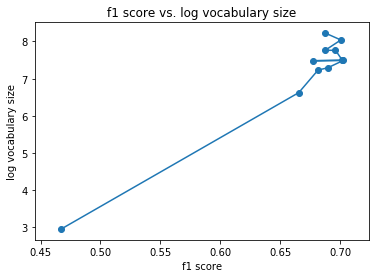

In [59]:
def P6():
        # Keep this random seed here to make comparison easier.
        #np.random.seed(0)

        ### STUDENT START ###
    proj_section_header(6)
    #transform training and dev data    
    train_cv_unigram = CountVectorizer(analyzer='word')
    train_ft_cv_unigram = train_cv_unigram.fit_transform(train_data)
    dev_t_cv_unigram = train_cv_unigram.transform(dev_data)


    train_ft_cv_unigram_array = train_ft_cv_unigram.toarray()
    dev_t_cv_unigram_array = dev_t_cv_unigram.toarray()


    header('For several L1 regularization strengths, produce a Logistic Regression model using the L1 regularization \
    strength. Reduce the vocabulary to only those features that have at least one non-zero weight among the four \
    categories. Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization \
    strength of 0.5. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated \
    with the new model.')

    def part_5_one_implementation(L1_value):
        #Produce a Logistic Regression model using the L1 regularization strength.
        p15s1_log_reg = LogisticRegression(C=L1_value, solver="liblinear", multi_class="auto", penalty="l1",tol=0.015)
        p15s1_log_reg.fit(train_ft_cv_unigram, train_labels)

        #Reduce the vocabulary to only those features that have at least one non-zero weight among 
        #the four categories. 

        def only_features_with_at_least_one_nonzero_weight_among_the_four_categories(log_reg, 
                                                                                     fit_transformed_cv_array_to_alter,
                                                                                    ):
            weights = log_reg.coef_
            drop_these_indexes_in_each_row = []
            for element_index in range(len(weights[0])):
                at_least_one_nonzero_for_this_element = []
                for row_index in range(len(weights)):
                    if weights[row_index][element_index] != 0:
                        at_least_one_nonzero_for_this_element.append(True)
                if sum(at_least_one_nonzero_for_this_element)==0:
                    drop_these_indexes_in_each_row.append(element_index)

            new_train_ft_cv_unigram_array = []        
            for row in fit_transformed_cv_array_to_alter:       
                new_row = np.delete(row,drop_these_indexes_in_each_row)  
                new_row = list(new_row)
                new_train_ft_cv_unigram_array.append(new_row)
            new_train_ft_cv_unigram_array = np.array(new_train_ft_cv_unigram_array)
            return new_train_ft_cv_unigram_array
        new_train_ft_cv_unigram_array = only_features_with_at_least_one_nonzero_weight_among_the_four_categories(p15s1_log_reg, train_ft_cv_unigram_array)
        new_dev_t_cv_unigram_array = only_features_with_at_least_one_nonzero_weight_among_the_four_categories(p15s1_log_reg, dev_t_cv_unigram_array)

        #Produce a new Logistic Regression model using the reduced vocabulary and 
        #L2 regularization strength of 0.5. 
        l2_log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto", penalty="l2", tol=0.015)
        l2_log_reg.fit(new_train_ft_cv_unigram_array, train_labels)
        l2_dev_preds = l2_log_reg.predict(new_dev_t_cv_unigram_array)


        #Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
        f1 = metrics.f1_score(dev_labels, l2_dev_preds, average="weighted")
        vocab_size = new_train_ft_cv_unigram_array.shape[1]

        return [L1_value, f1, vocab_size]

    #L1_strengths = np.arange(.01,10,.5)
    L1_strengths = np.append(np.arange(.01,3,.5),np.arange(3,10,1.5))

    L1_value_list = []
    f1_list = []
    vocab_size_list = []

    for i in L1_strengths:
        the_vals = part_5_one_implementation(i)
        L1_value_list.append(the_vals[0])
        f1_list.append(the_vals[1])
        vocab_size_list.append(the_vals[2])

    for i in range(len(L1_value_list)):
        print('L1 regularization strength:', L1_value_list[i])
        print('f1 score: ',f1_list[i])
        print('Vocabulary Size: ', vocab_size_list[i])
        print('----------------------------------------------------')
        print()

    #Show a plot of f1 score vs. log vocabulary size.
    #Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

    plt.scatter(f1_list, np.log(vocab_size_list))
    plt.plot(f1_list, np.log(vocab_size_list))
    plt.xlabel('f1 score')
    plt.ylabel('log vocabulary size')
    plt.title('f1 score vs. log vocabulary size')

    #How does performance of the models based on reduced vocabularies compare to that 
    #of a model based on the full vocabulary?
    
    
    
    ### STUDENT END ###

P6()

ANSWER:
    Models with larger vocabulary sizes perform better when measured by f1 score

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [28]:
def P7():
    ### STUDENT START ###
    proj_section_header(7)
    header('1. A Logistic Regression model is produced based on data represented in tf-idf form, with L2 \
regularization strength of 100. Its f1 score is evaluated and shown')

    #use tfidfvectorizer to vectorize training and dev data
    train_tfidf_unigram = TfidfVectorizer(analyzer='word')
    train_ft_tfidf_unigram = train_tfidf_unigram.fit_transform(train_data)
    dev_t_tfidf_unigram = train_tfidf_unigram.transform(dev_data)

    #convert tfidf vectorized data to arrays
    train_ft_tfidf_unigram_array = train_ft_tfidf_unigram.toarray()
    dev_t_tfidf_unigram_array = dev_t_tfidf_unigram.toarray()

    #Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100
    tfidf_log_reg = LogisticRegression(C=100, solver="liblinear", multi_class="auto")

    #fit tfidf logistic regression model
    tfidf_log_reg.fit(train_ft_tfidf_unigram, train_labels)

    #predict dev data with tfidf logistic regression model
    tfidf_log_reg_dev_preds = tfidf_log_reg.predict(dev_t_tfidf_unigram)

    #Evaluate and show the f1 score
    f1 = metrics.f1_score(dev_labels, tfidf_log_reg_dev_preds, average="weighted")
    print('f1 score: ',f1)
    end_section()

    header('2. The 3 Documents in the Dev Data With the Highest R Ratio Are Shown')
    #Calculate R ratio
    pred_proba = tfidf_log_reg.predict_proba(dev_t_tfidf_unigram)
    pred_proba_maxs = np.array([np.max(i) for i in pred_proba])
    pred_proba_correct_label = np.array([pred_proba[i][dev_labels[i]] for i in range(len(pred_proba))])
    r_ratio = pred_proba_maxs/pred_proba_correct_label
    
    #Show the 3 documents with highest R ratio
    sorted_r_ratios = np.sort(r_ratio)[::-1]
    top_3_r_ratios = [i for i in sorted_r_ratios[0:3]]
    sorted_r_ratios_indexes = np.argsort(r_ratio)[::-1]
    top_3_r_ratios_indexes = sorted_r_ratios_indexes[:3]
    
    #predicted label for 3 documents with highest R ratio
    predicted_label = [tfidf_log_reg_dev_preds[i] for i in top_3_r_ratios_indexes]
    #actual label for 3 documents with highest R ratio
    actual_label = [dev_labels[i] for i in top_3_r_ratios_indexes]
    
    def top_3_r_ratio_docs():
        ### STUDENT START ###
        start = "\033[1m"
        end = "\033[0;0m"
        fst = ['','second','third']
        for i in range(3):
            print(start+'The Document in dev_data with the '+fst[i]+' Highest R Ratio:')
            print()
            print(start+'R Ratio: '+end, top_3_r_ratios[i])
            print(start+'Index: '+end, top_3_r_ratios_indexes[i])
            print(start+'Predicted Label: '+end, predicted_label[i] )
            print(start+'Predicted Label Name: '+end, newsgroups_train.target_names[predicted_label[i]])
            print(start+'Actual Label: '+end, actual_label[i] )
            print(start+'Actual Label Name: '+end, newsgroups_train.target_names[actual_label[i]])
            print(start + 'Text:' + end)
            print(dev_data[top_3_r_ratios_indexes[i]])
            print('------------------------------------------------------------------------------')


    top_3_r_ratio_docs()
    end_section()
    ### STUDENT END ###

P7()

Project Part 7 : 
~~~~~~~~~~~~~~~~~~~~~~~~~


1. A Logistic Regression model is produced based on data represented in tf-idf form, with L2 regularization strength of 100. Its f1 score is evaluated and shown 

f1 score:  0.7597662427853104
----------------------------------------------------------------------------------------------------------------------


2. The 3 Documents in the Dev Data With the Highest R Ratio Are Shown 

The Document in dev_data with the  Highest R Ratio:

R Ratio:  929.3575135805266
Index:  215
Predicted Label:  1
Predicted Label Name:  comp.graphics
Actual Label:  3
Actual Label Name:  talk.religion.misc
Text:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and 

ANSWER:

1.  How is TfidfVectorizer different than CountVectorizer?
    
        TfidfVectorizer stands for term frequency inverse data frequency vectorizer. It differs from CountVectorizer because CountVectorizer counts the frequency of each word in the vocabulary, whereas TfidfVectorizer outputs values proportional to count and inversely proportional to frequency.
    
    
2. Explain what the R ratio describes.
    
        The R ratio describes the ratio between the highest probability (the probability for the prediction that will be made by the model) to the probability that the model gives to the true label. In effect, R value shows how far off the model is for a particular document. A very high R ratio would mean that the model was very far off for the document, assigning a much higher probability to a wrong prediction than the correct prediction. An R ratio of 1 would mean that the correct label was predicted, because the highest probability, and therefore the probability of the predicted label, was the same as probability of the actual label (which was therefore the label with highest probability). The R ratio cannot be below 1 because the numerator is the highest probability, which cannot be below the probability for any other element.
        
2b.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.
    
    One issue with the model is that smaller documents are being classified incorrectly. One way to fix this issue might be to use CountVectorizer instead of TfidfVectorizer for documnts below a specific length
